In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import collections
import numpy as np

In [2]:
#look at table E
E = pd.read_csv("E.csv")
print(len(E))
E.head()

5194


,Album,Artist,Genre,Label,Producer,Release Date,Meta Score
0,Black and White Rainbows,Bush,"['pop rock', 'alternative rock']","['caroline', 'zuma rock records']","['bob rock', 'gavin rossdale']",Mar 10 2017,49.0
1,Different Creatures,Circa Waves,['pop rock'],['virgin emi'],['alan moulder'],Mar 10 2017,78.0
2,Elektrac,Shobaleader One,['electronic'],"['warp', 'wrap']",['squarepusher'],Mar 10 2017,71.0
3,Packs,Your Old Droog,"['hip hop', 'rap']","['fat beats', 'droog recordings', 'droog']","['e. dan', 'rtnc', 'your old droog', 'nice rec...",Mar 10 2017,81.0
4,Captain California,Murs,"['hip hop', 'rap']",['strange music'],"['buttercream bob', 'anthony cruz', 'mr. len',...",Mar 10 2017,82.0


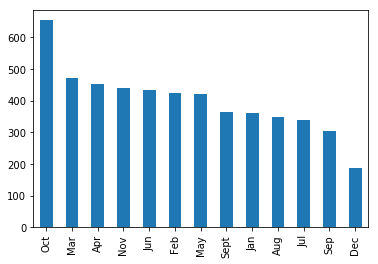

In [3]:
#plot by month release date
months = E["Release Date"].str.split(" ").apply(lambda x: x[0])
months.value_counts().plot(kind="bar")

E_months = E.copy()
E_months["Release Date"] = months

In [4]:
#show top genre pairs
E_filtered = E[pd.notnull(E['Meta Score'])]
genres = E_filtered["Genre"].tolist()

def create_pairs(genre_list):
    pairs = []
    indicies = xrange(len(genre_list))
    combos = itertools.combinations(indicies,2)
    for i,j in combos:
        p = [genre_list[i],genre_list[j]]
        p.sort()
        pairs.append(tuple(p))
    return pairs

def strlist_to_list(genre_list):
    if type(genre_list) != str:
        genre_list = ""
    for c in ["[","]","'"]:
        genre_list = genre_list.replace(c,"")
    genre_list = genre_list.split(",")
    genre_list = map(lambda x: x.strip(),genre_list)
    return genre_list

genre_lists = map(strlist_to_list,genres)
print(genre_lists[0:10])
pairs = []
for genre_list in genre_lists:
    p = create_pairs(genre_list)
    pairs.extend(p)

counts = collections.Counter(pairs)
print(counts.most_common(10))

[['pop rock', 'alternative rock'], ['pop rock'], ['electronic'], ['hip hop', 'rap'], ['hip hop', 'rap'], ['pop rock', 'alternative rock'], ['electronica', 'pop rock'], ['post-punk', 'pop rock'], ['electronic'], ['indie pop', 'pop rock', 'indie rock']]
[(('indie rock', 'pop rock'), 97), (('hip hop', 'rap'), 82), (('alternative rock', 'pop rock'), 67), (('pop rock', 'rock'), 63), (('pop', 'pop rock'), 37), (('indie pop', 'pop rock'), 29), (('r&b', 'soul'), 24), (('pop rock', 'punk rock'), 22), (('hard rock', 'pop rock'), 22), (('pop', 'r&b'), 21)]


In [5]:
#Build regression model based on genre

#Make one hot encoding
from collections import defaultdict

#create genres set
genres_dict = defaultdict(int)
for l in genre_lists:
    for g in l:
        if g != "":
            genres_dict[g] += 1

#create mapping of genre to feature
genre_mapping = {}
i = 0
for g,count in genres_dict.items():
    if count > 10: #needs to occur at least 10 times for us to consider it
        genre_mapping[g] = i
        i += 1
print "One hot mapping: " + str(genre_mapping)

#create feature vectors
X = []
for l in genre_lists:
    x = [0 for i in xrange(len(genre_mapping))]
    for genre in l:
        if genre in genre_mapping:
            x[genre_mapping[genre]] = 1
    X.append(x)

One hot mapping: {'folk rock': 0, 'pop punk': 27, 'classical': 13, 'ambient': 39, 'pop': 29, 'na': 40, 'new wave': 14, 'rap': 38, 'heavy metal': 1, 'alternative indie rock': 30, 'blues': 15, 'hard rock': 31, 'progressive rock': 16, 'folk': 17, 'alternative rock': 2, 'garage rock': 18, 'art rock': 42, 'pop rock': 33, 'americana': 28, 'indie rock': 19, 'electronica': 20, 'electronic': 32, 'dream pop': 41, 'r&b': 21, 'post-punk': 3, 'alternative r&b': 43, 'international': 22, 'hip hop': 23, 'experimental rock': 4, 'punk rock': 44, 'jazz': 45, 'indie folk': 5, 'art pop': 6, 'avant-garde': 7, 'post-hardcore': 46, 'metalcore': 37, 'funk': 34, 'country': 36, 'emo': 9, 'punk': 25, 'soul': 35, 'electropop': 8, 'psychedelic rock': 10, 'trap': 11, 'rock': 12, 'indie pop': 24, 'synth-pop': 26, 'experimental': 47}


In [16]:
labels = E_filtered["Meta Score"].tolist()

#get train test split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,y_train,y_test = train_test_split(X,labels,test_size=.15,random_state=23)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import sklearn.metrics
clf = LinearRegression()
clf.fit(Xtrain,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Train ME: 5.5655695522
Test ME: 5.91740747357


(array([   2.,    3.,   23.,  108.,  155.,  100.,   36.,   17.,    4.,    3.]),
 array([-27.95786046, -21.9367011 , -15.91554173,  -9.89438237,
         -3.87322301,   2.14793636,   8.16909572,  14.19025508,
         20.21141444,  26.23257381,  32.25373317]),
 <a list of 10 Patch objects>)

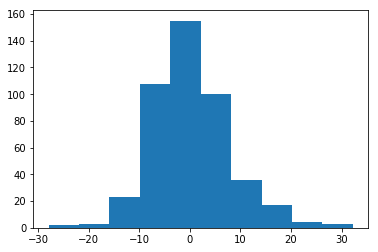

In [18]:
train_predictions = clf.predict(Xtrain)
test_predictions = clf.predict(Xtest)
train_mse = sklearn.metrics.mean_absolute_error(y_train,train_predictions)
test_mse = sklearn.metrics.mean_absolute_error(y_test,test_predictions)
print("Train ME: " + str(train_mse))
print("Test ME: " + str(test_mse))
plt.hist(test_predictions-y_test)

In [19]:
#look at weights on each genre
#clf.feature_importances_
weights = [(i,clf.coef_[i]) for i in xrange(len(clf.coef_))] #save index and weight

weights.sort(key=lambda x: x[1],reverse=True)

#top 10
top = weights[0:10]
print("\n--Top--")
for i,w in top:
    for g,index in genre_mapping.items():
        if i == index:
            print(g + " : " + str(w))

#bottom 10
print("\n--Bottom--")
bottom = weights[-10:]
bottom.reverse()
for i,w in bottom:
    for g,index in genre_mapping.items():
        if i == index:
            print(g + " : " + str(w))



--Top--
metalcore : 6.80292292147
art rock : 6.14239638149
punk : 5.86100602231
ambient : 5.55386144934
post-punk : 5.17134451759
folk rock : 5.12175950631
art pop : 4.21428800144
avant-garde : 4.16146017938
emo : 3.93981232538
americana : 3.70005875919

--Bottom--
pop : -5.60978432047
alternative rock : -5.60378433392
indie pop : -4.28203942885
hard rock : -3.2115936284
synth-pop : -3.14169452885
hip hop : -2.6261254664
na : -2.16705587243
rock : -2.15675389875
soul : -1.79356802289
progressive rock : -1.58146810761
